In [41]:
# Install spinningup on CoLab
!git clone https://github.com/openai/spinningup.git
!cd spinningup
#!pip install -e . # this will incur error: File "setup.py" not found. Directory cannot be installed in editable mode: /content
!pip install --user -e spinningup

fatal: le chemin de destination 'spinningup' existe déjà et n'est pas un répertoire vide.
Obtaining file:///run/media/maxime/Documents/_ENS/M2/deepl_rl/tp-rl-dl/tp-rl/spinningup
  Using cached https://files.pythonhosted.org/packages/09/f4/4a080c349c1680a2086196fcf0286a65931708156f39568ed7051e42ff6a/cloudpickle-1.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/12/d1/7b12cd79c791348cb0c78ce6e7d16bd72992f13c9f1e8e43d2725a6d8adf/matplotlib-3.1.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/ec/8f/bbd8de5ba566dd77e408d8136e2bab7fdf2b97ce06cab830ba8b50a2f588/mpi4py-3.0.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/a5/c0/34033b2df7718b91c667bd259d5ce632ec3720198b7068c0ba6f6104ff89/pytest-5.3.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/10/01/dd1c7838cde3b69b247aaeb61016e238cafd8188a276e366d36aa6bcdab4/seaborn-0.8.1.tar.gz
ERROR: Could not find a version that satisfies the requirement tensorflow<2.0,

In [42]:
!pip install --user spinup

In [43]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor

In [44]:
import os
import pickle

import gym

import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from copy import deepcopy
from collections import namedtuple, deque

import matplotlib.pyplot as plt

In [45]:
#CONSTANTS

ENV = 'CartPole-v0'
#Upgrade values
BETA    = 0.2
DELTA   = 1
GAMMA   = 0.995
EPSILON = 0.3
TAU     = 0.97

#Memory and number of runs
N_EPISODES = 2
BATCH_SIZE = 1000

#Model hyperparameters
N_HIDDEN        = 64
A_LEARNING_RATE = 0.001
C_LEARNING_RATE = 0.0001          #Current best : 0.001 & 0.001, mean reward ~ 22 with cartpole

# Unterval of steps after which statistics should be printed
LOG_STEPS = 1
SAVE_STEPS = 20
#ACTOR_SAVE_PATH = "saved_models/actor_ppo.pth"
#CRITIC_SAVE_PATH = "saved_models/critic_ppo.pth"

In [46]:
class Game:
    """
    Running environment, taking one step,...
    """
    def __init__(self):
        self.env = gym.make(ENV)
        self.state_dim = self.env.observation_space.shape[0]
        self.n_actions = self.env.action_space.n
        # typecast since problems with multiplication if type(limit) = np.float32
        #self.limit = float(self.env.action_space.high[0])

    def reset(self):
        start = self.env.reset()
        return start

    def take_one_step(self, action):
        #new_frame, reward, is_done, _ = self.env.step([action])
        new_frame, reward, is_done, _ = self.env.step(action)
        return new_frame, reward, is_done

    def sample_action(self):
        return self.env.action_space.sample()

In [47]:
Transition = namedtuple('Transition', ('state', 'action', 'mask', 'reward'))

class Memory(object):
    """
    Save state,action,reward,mask to memory,
    Sample from memory with .sample()
    """
    def __init__(self):
        self.memory = []

    def push(self, state, action, mask, reward):
        """Saves a transition."""
        self.memory.append(Transition(state, action, mask, reward))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

In [48]:
class Actor(nn.Module):
    """
    Actor Critic network
    """
    def __init__(self, n_inp, n_hidden,n_output):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(n_inp, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_output)
        
        #nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
        #nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)


        #self.log_stddev = nn.Parameter(torch.zeros(1))

        self.module_list = [self.fc1, self.fc2]
        self.module_list_old = [None] * 2

        # required so that start of episode does not throw error
        n = n_inp
        y = 1.0/np.sqrt(n)

        fc1_old = self.fc1
        fc2_old = self.fc2
        
        #Weights init
        fc1_old.weight.data.uniform_(-y, y)
        fc2_old.bias.data.fill_(0)

        self.module_list_old[0], self.module_list_old[1] = fc1_old, fc2_old

    def backup(self):
        for i in range(len(self.module_list)):
            self.module_list_old[i] = deepcopy(self.module_list[i])

    def forward(self, x, old=False):
        
        
        if not old:
            x = F.tanh(self.fc1(x))
        
            x = F.softmax(self.fc2(x), dim=-1)
            #mu = self.mean(x)
            #log_stddev = self.log_stddev.expand_as(mu)
        else:
            x = F.tanh(self.module_list_old[0](x))
            x = F.softmax(self.module_list_old[1](x), dim=-1)

        return x


class Critic(nn.Module):
    def __init__(self, n_inp, n_hidden):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(n_inp, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)

        #Weights init
        self.state_val = nn.Linear(n_hidden, 1)
        self.state_val.weight.data.mul_(0.1)
        self.state_val.bias.data.mul_(0.0)

    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        state_val = self.state_val(x)
        return state_val

In [49]:
def plot_data(statistics):
    '''
    plots reward and loss graph for entire training
    '''
    x_axis = np.linspace(0, N_EPISODES, N_EPISODES // LOG_STEPS)
    plt.plot(x_axis, statistics["reward"])
    plt.title("Variation of mean rewards")
    plt.show()

    plt.plot(x_axis, statistics["val_loss"])
    plt.title("Variation of Critic Loss")
    plt.show()

    plt.plot(x_axis, statistics["policy_loss"])
    plt.title("Variation of Actor loss")
    plt.show()

In [50]:
class PPO:
    def __init__(self, env, actor, critic, KL=False,Clip=True):
        self.env = env
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=A_LEARNING_RATE)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=C_LEARNING_RATE)
        self.kl=KL
        self.clip = Clip
        self.num_outputs = env.n_actions

    def select_best_action(self, S, countinuous=False):
      if countinuous:
        S = torch.FloatTensor(S)
        mu, log_sigma = self.actor(Variable(S))
        action = torch.normal(mu, torch.exp(log_sigma))
        return action
      else:
        S = Variable(torch.FloatTensor(S))
        dist = self.actor(S)
        action = np.random.choice(self.num_outputs, p=np.squeeze(dist.detach().numpy()))
        return action

    def compute_advantage(self, values, batch_R, batch_mask):
        batch_size = len(batch_R)

        v_target = torch.FloatTensor(batch_size)
        advantages = torch.FloatTensor(batch_size)

        prev_v_target = 0
        prev_v = 0
        prev_A = 0

        for i in reversed(range(batch_size)):
            v_target[i] = batch_R[i] + GAMMA * prev_v_target * batch_mask[i]
            delta = batch_R[i] + GAMMA * prev_v * batch_mask[i] - values.data[i]
            advantages[i] = delta + GAMMA * TAU * prev_A * batch_mask[i]

            prev_v_target = v_target[i]
            prev_v = values.data[i]
            prev_A = advantages[i]

        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-4)
        return advantages, v_target

    def update_params(self, batch,i):
        S = torch.FloatTensor(batch.state)
        masks = torch.FloatTensor(batch.mask)
        A = torch.FloatTensor(np.concatenate(batch.action, 0))
        R = torch.FloatTensor(batch.reward)

        V_S = self.critic(Variable(S))
        advantages, v_target = self.compute_advantage(V_S, R, masks)

        # loss function for value net
        L_vf = torch.mean(torch.pow(V_S - Variable(v_target), 2))

        # optimize the critic net
        self.critic_optimizer.zero_grad()
        L_vf.backward()
        self.critic_optimizer.step()

        # cast into variable
        #A = Variable(A)
        A = torch.tensor(A,dtype=torch.int8).numpy()
        # new log probability of the actions
        #means, log_stddevs = self.actor(Variable(S))
        #new_log_prob = get_gaussian_log(A, means, log_stddevs)
        new_prob = self.actor(Variable(S))
        new_log_prob = torch.log(new_prob[np.arange(0,len(new_prob)),A])

        # old log probability of the actions
        with torch.no_grad():
            #old_means, old_log_stddevs = self.actor(Variable(S), old=True)
            #old_log_prob = get_gaussian_log(A, old_means, old_log_stddevs)
            old_prob = self.actor(Variable(S),old=True)
            old_log_prob = torch.log(old_prob[np.arange(0,len(old_prob)),A])

        # save the old actor
        
        self.actor.backup()

        #Adding an entropy term to critic loss, not sure it's a good idea
        entropy = - (torch.sum((new_prob) * torch.log(new_prob),dim=1)).mean()

        # ratio of new and old policies
        ratio = torch.exp(new_log_prob - old_log_prob)

        # find clipped loss
        if self.clip:
          advantages = Variable(advantages)
          L_cpi = ratio * advantages
          clip_factor = torch.clamp(ratio, 1 - EPSILON, 1 + EPSILON) * advantages
          L_clip = -torch.mean(torch.min(L_cpi, clip_factor))
          actor_loss = L_clip + BETA*entropy
          
          #It is too little otherwise
          actor_loss *= 10

        elif self.kl:
            #To code
            pass

        else:
          actor_loss = -torch.mean(ratio * Variable(advantages)) + BETA * entropy
          actor_loss*=10



        # optimize actor network
        self.actor_optimizer.zero_grad()
        actor_loss.backward()

        if self.clip:
          torch.nn.utils.clip_grad_norm_(self.actor.parameters(),100)

        self.actor_optimizer.step()

        return actor_loss, L_vf

<ipython-input-50-85885f97cb57>:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A,dtype=torch.int8).numpy()


Episode: 0, Mean Reward: 19.82352941, Mean Value loss: [267.49127197],Mean Policy Loss: [1.38158214]
Episode: 20, Mean Reward: 21.52484916, Mean Value loss: [291.33793411],Mean Policy Loss: [1.38514555]
Episode: 40, Mean Reward: 22.63424539, Mean Value loss: [321.86511536],Mean Policy Loss: [1.38594722]
Episode: 60, Mean Reward: 23.31764015, Mean Value loss: [359.31423721],Mean Policy Loss: [1.38593174]
Episode: 80, Mean Reward: 22.69263226, Mean Value loss: [335.50913391],Mean Policy Loss: [1.38617246]
Episode: 100, Mean Reward: 22.13108115, Mean Value loss: [302.43323746],Mean Policy Loss: [1.38599812]
Episode: 120, Mean Reward: 22.02134878, Mean Value loss: [279.39322205],Mean Policy Loss: [1.38622103]
Episode: 140, Mean Reward: 23.58182346, Mean Value loss: [340.03531036],Mean Policy Loss: [1.38620074]
Episode: 160, Mean Reward: 22.57014939, Mean Value loss: [318.42008972],Mean Policy Loss: [1.38535187]
Episode: 180, Mean Reward: 22.06440539, Mean Value loss: [285.53724594],Mean Po

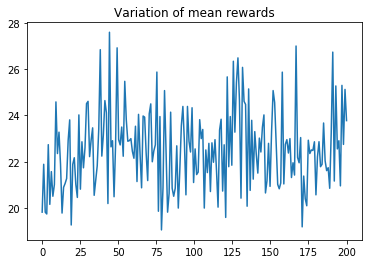

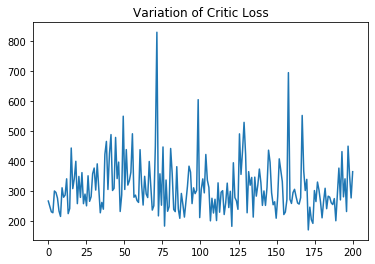

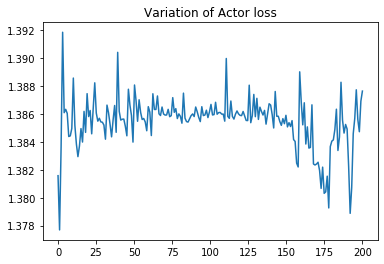

In [51]:
env = Game()
n_input = env.state_dim
num_outputs = env.n_actions

actor = Actor(n_input, N_HIDDEN, num_outputs)
critic = Critic(n_input, N_HIDDEN)


ppo_agent = PPO(env, actor, critic, KL=False, Clip=True)

#running_state = ZFilter((2,), clip=5)

statistics = {
    'reward': [],
    'val_loss': [],
    'policy_loss': [],
}

N_EPISODES = 200
MEM_BATCH_SIZE = 1000

best_reward = 0
for i in range(0, N_EPISODES):
    memory = Memory()
    num_steps = 0
    num_ep = 0
    reward_batch = 0

    while num_steps < MEM_BATCH_SIZE:
        S = env.reset()
        #S = running_state(S)
        t = 0
        reward_sum = 0

        while True:
            t += 1

            A = ppo_agent.select_best_action(S)
            S_prime, R, is_done = env.take_one_step(A) #a.item()

            reward_sum += R
            mask = 1 - int(is_done)

            memory.push(S, np.array([A]), mask, R)      #a.item()

            if is_done:
                break

            #S = running_state(S_prime)
            # S = S_prime

        num_steps += t
        num_ep += 1
        reward_batch += reward_sum

    reward_batch /= num_ep

    # The memory is now full of rollouts. Sample from memory and optimize
    batch = memory.sample()
    policy_loss, val_loss = ppo_agent.update_params(batch,i)


    # log data onto stdout
    if i == 0 or i % LOG_STEPS == 0:
        # save statistics
        statistics['reward'].append(reward_batch)
        statistics['val_loss'].append(val_loss.item())
        statistics['policy_loss'].append(policy_loss.item())
        
        if i % 20 == 0:
          print("Episode: %d, Mean Reward: %.8f, Mean Value loss: [%.8f],Mean Policy Loss: [%.8f]" %(i, np.asarray(statistics['reward'][-20:]).mean(), 
                                                                                                     np.asarray(statistics['val_loss'][-20:]).mean(), 
                                                                                                         np.asarray(statistics['policy_loss'][-20:]).mean()))

plot_data(statistics)

In [52]:
a = np.zeros([52])

In [53]:
a[40]+=1

In [54]:
a[50]+=1

In [55]:
a[-20:]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0.])

In [56]:
b = np.array([3,3,3,3])

In [57]:
b[-20:]

array([3, 3, 3, 3])

In [58]:
import spinningup

In [59]:
help(spinningup)

Help on package spinningup:

NAME
    spinningup

PACKAGE CONTENTS
    setup
    spinup (package)

FILE
    (built-in)




In [60]:
import spinningup.spinup

ModuleNotFoundError: No module named 'spinup.algos'